<a href="https://colab.research.google.com/github/w1767/w1767/blob/main/Garch%2C_Monte_Carlo%2C_LSTM%2C_SVM_and_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install matplotlib==3.1.3

In [19]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px black solid !important;
    color: black !important;
}
</style>

In [20]:
!pip install arch
!pip install tensor
!pip install tensorflow
!pip install statsmodels
!pip install keras
!pip install sklearn
import tensorflow
import keras
import sklearn
from pathlib import Path
from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
from arch import arch_model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import os
import glob
import csv
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
path = "/content/drive/MyDrive/Master thesis/Vix.csv"

In [23]:
VI_db=pd.read_csv("/content/drive/MyDrive/Master thesis/VIX.csv")

In [24]:
VI_db

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/1990,17.240000,17.240000,17.240000,17.240000,17.240000,0
1,03/01/1990,18.190001,18.190001,18.190001,18.190001,18.190001,0
2,04/01/1990,19.219999,19.219999,19.219999,19.219999,19.219999,0
3,05/01/1990,20.110001,20.110001,20.110001,20.110001,20.110001,0
4,08/01/1990,20.260000,20.260000,20.260000,20.260000,20.260000,0
...,...,...,...,...,...,...,...
7929,22/06/2021,17.910000,18.320000,15.760000,16.660000,16.660000,0
7930,23/06/2021,16.250000,16.840000,14.860000,16.320000,16.320000,0
7931,24/06/2021,15.990000,16.049999,14.190000,15.970000,15.970000,0
7932,25/06/2021,16.040001,16.170000,15.210000,15.620000,15.620000,0


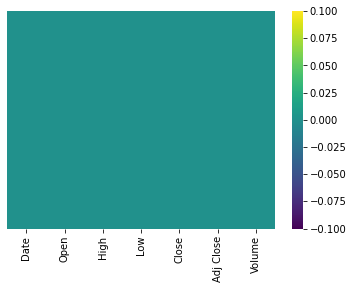

In [25]:
import seaborn as sns
sns.heatmap(VI_db.isnull(), yticklabels=False, cmap="viridis")

In [26]:
import numpy as np

In [27]:
#DATA TYPE FORMATTING OF THE REQUIRED FEATURES
VI_db['Date'] = pd.to_datetime(VI_db['Date'])
VI_db['log_price'] = np.log(VI_db['Close'])
VI_db['pct_change'] = VI_db['log_price'].diff()
VI_db['st_dev'] = VI_db['pct_change'].rolling(window=30, center=False).std()


In [28]:
VI_db['Volatility'] = VI_db['st_dev']*(252**0.5)

In [29]:
VI_db.head(100)

,Date,Open,High,Low,Close,Adj Close,Volume,log_price,pct_change,st_dev,Volatility
0,1990-02-01,17.240000,17.240000,17.240000,17.240000,17.240000,0,2.847232,NaN,NaN,NaN
1,1990-03-01,18.190001,18.190001,18.190001,18.190001,18.190001,0,2.900872,0.053640,NaN,NaN
2,1990-04-01,19.219999,19.219999,19.219999,19.219999,19.219999,0,2.955951,0.055079,NaN,NaN
3,1990-05-01,20.110001,20.110001,20.110001,20.110001,20.110001,0,3.001217,0.045266,NaN,NaN
4,1990-08-01,20.260000,20.260000,20.260000,20.260000,20.260000,0,3.008648,0.007431,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,1990-05-17,17.270000,17.270000,17.270000,17.270000,17.270000,0,2.848971,-0.025159,0.069642,1.105535
96,1990-05-18,17.200001,17.200001,17.200001,17.200001,17.200001,0,2.844909,-0.004061,0.069416,1.101950
97,1990-05-21,16.719999,16.719999,16.719999,16.719999,16.719999,0,2.816606,-0.028304,0.069241,1.099169
98,1990-05-22,17.840000,17.840000,17.840000,17.840000,17.840000,0,2.881443,0.064838,0.070293,1.115870


In [30]:
# Set 'Date' as index


In [31]:
to_plt = VI_db.sort_values(by = 'Date').set_index('Date')

Text(0.5, 1.0, 'Vix Rolling Volatility considering 30 Time Periods with Standard Deviation Annualized')

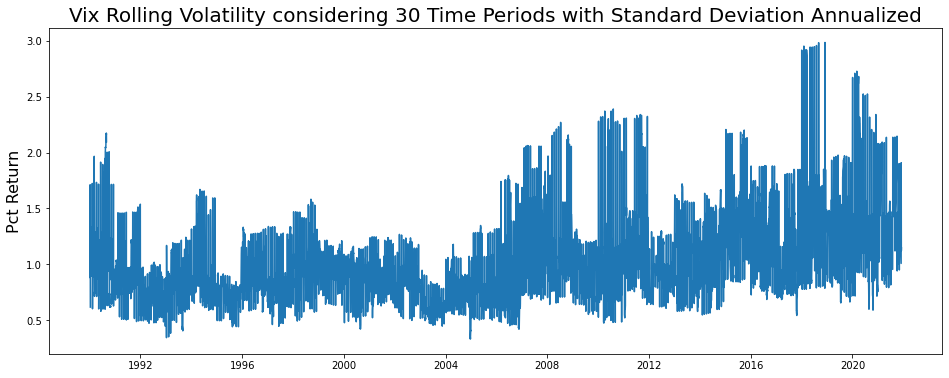

In [34]:
plt.figure(figsize=(16,6))
plt.plot(to_plt['Volatility'])
plt.ylabel('Pct Return', fontsize=16)
plt.title('Vix Rolling Volatility considering 30 Time Periods with Standard Deviation Annualized', fontsize=20)

In [35]:
df=to_plt.dropna()

In [36]:
vol = df['Volatility'] * 100

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7904 entries, 1990-01-03 to 2021-12-05
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        7904 non-null   float64
 1   High        7904 non-null   float64
 2   Low         7904 non-null   float64
 3   Close       7904 non-null   float64
 4   Adj Close   7904 non-null   float64
 5   Volume      7904 non-null   int64  
 6   log_price   7904 non-null   float64
 7   pct_change  7904 non-null   float64
 8   st_dev      7904 non-null   float64
 9   Volatility  7904 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 679.2 KB


In [38]:
# To check if there is null value in any of the column
df.isnull().any()

Open          False
High          False
Low           False
Close         False
Adj Close     False
Volume        False
log_price     False
pct_change    False
st_dev        False
Volatility    False
dtype: bool

In [39]:
# Replacing the missing values with df.mean()
VI_db.replace([np.inf, -np.inf], np.nan, inplace=True)
VI_db.fillna(df.mean(), inplace=True)

In [ ]:
#Performing the ADF test to identify if the return series is stationary or non-stationary

In [40]:
result = adfuller(df.Volatility)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.631603
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
#Volatility Prediction using Garch(3,1)

In [41]:
GARCH_Mod = arch_model(vol, vol='Garch', p=3, o=0, q=1, dist='Normal')

In [ ]:
#GARCH SUMMARY

In [43]:
re = GARCH_Mod = arch_model(vol, vol='Garch', p=3, o=0, q=1, dist='Normal')

In [ ]:
#GARCH SUMMARY

In [44]:
res = GARCH_Mod.fit(disp='off')
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -38027.9
Distribution:                  Normal   AIC:                           76067.8
Method:            Maximum Likelihood   BIC:                           76109.7
                                        No. Observations:                 7904
Date:                Sat, Feb 05 2022   Df Residuals:                     7903
Time:                        16:13:11   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            88.8884      0.975     91.129      0.000 [ 86.977, 90.800]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega        110.8323     42.483      2.609  9.084e-03 [ 27.567,1.941e+02]
alpha[1]       0.4793  5.058e-02      9.476  2.640e-21   [  0.380,  0.578]
alpha[2]   1.2435e-09      0.101  1.235e-08      1.000   [ -0.197,  0.197]
alpha[3]       0.0000  8.964e-02      0.000      1.000   [ -0.176,  0.176]
beta[1]        0.5048      0.175      2.890  3.856e-03   [  0.162,  0.847]
==========================================================================

Covariance estimator: robust
"""

In [45]:
#CREATING FORECASTED VOLATILITY FEATURE
# The below is straightforward. i will use the garch function provided by the arch python module to get omega, beta and alpha.
#following the formula σ2t=ω+α1a2t−1+β1σ2t−1, i execute the following code. th ecorrect formula for forecast_vol should be:
#0.01 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid2 + res.conditional_volatility2 * res.params['beta[1]'])

In [46]:
df['forecast_vol'] = 0.01 * np.sqrt(res.params['omega'] + res.params['alpha[1]']* res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

In [47]:
df['Volatility'].head(20)

Date
1990-01-03    0.893589
1990-01-05    1.334283
1990-01-06    0.881965
1990-01-08    1.712147
1990-01-10    0.947622
1990-01-11    0.618401
1990-02-03    0.895341
1990-02-04    1.017414
1990-02-05    1.335973
1990-02-07    1.268275
1990-02-08    1.723761
1990-02-10    0.943967
1990-02-11    0.603746
1990-02-13    1.072026
1990-02-14    1.091692
1990-02-15    1.133728
1990-02-16    1.136526
1990-02-20    1.166584
1990-02-21    1.144704
1990-02-22    1.157712
Name: Volatility, dtype: float64

In [48]:
df['forecast_vol'].head(20)

Date
1990-01-03    0.251570
1990-01-05    0.371623
1990-01-06    0.284285
1990-01-08    0.613758
1990-01-10    0.450428
1990-01-11    0.385432
1990-02-03    0.293414
1990-02-04    0.249915
1990-02-05    0.372032
1990-02-07    0.387209
1990-02-08    0.648702
1990-02-10    0.474294
1990-02-11    0.404476
1990-02-13    0.331270
1990-02-14    0.293580
1990-02-15    0.288653
1990-02-16    0.287285
1990-02-20    0.299504
1990-02-21    0.296188
1990-02-22    0.300002
Name: forecast_vol, dtype: float64

In [49]:
pip install openpyxl

In [50]:
df['Volatility'].to_excel('g_a.xlsx') #to export actual value of Garch Model

In [53]:
df['forecast_vol'].to_excel('g_p.xlsx')#to export predicted value of Garch Model

In [ ]:
#PLOTTING ACTUAL VOLATILITY VS FORECASTED VOLATILITY

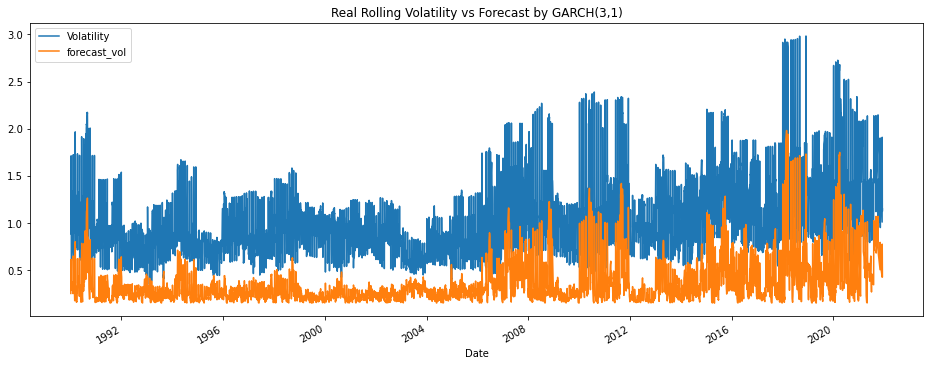

In [56]:
plt.figure(figsize=(16,6))
df["Volatility"].plot()
df["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(3,1)")
plt.legend()
plt.show()

In [66]:
#Calculating RMSE value for GARCH Model
print('RMSE calculated for GARCH(3,1) model:', np.sqrt(metrics.mean_squared_error(df.loc[df.index[1000:], 'Volatility'], df.loc[df.index[1000:], 'forecast_vol'])))

RMSE calculated for GARCH(3,1) model: 0.7096122252850938


In [67]:
print('MAE calculated for GARCH(3,1) model:', MAE(df.loc[df.index[1000:], 'Volatility'], df.loc[df.index[1000:], 'forecast_vol']))

MAE calculated for GARCH(3,1) model: 0.6689068286747392


In [69]:
print('MAPE calculated for GARCH:', mean_absolute_percentage_error(df.loc[df.index[1000:], 'Volatility'], df.loc[df.index[1000:], 'forecast_vol' ]))

MAPE calculated for GARCH: 0.6595012286192034


In [ ]:
#Volatility Prediction using LSTM